In [1]:
import numpy as np #library to work with vectors and matrix
import matplotlib.pyplot as plt #library to work with graphics and plots
from scipy.optimize import fmin_l_bfgs_b

%matplotlib inline

In [2]:
def mnist(path=None):
    r"""Return (train_images, train_labels, test_images, test_labels).

    Args:
        path (str): Directory containing MNIST. Default is
            /home/USER/data/mnist or C:\Users\USER\data\mnist.
            Create if nonexistant. Download any missing files.

    Returns:
        Tuple of (train_images, train_labels, test_images, test_labels), each
            a matrix. Rows are examples. Columns of images are pixel values.
            Columns of labels are a onehot encoding of the correct class.
    """
    #Taken from: 'https://mattpetersen.github.io/load-mnist-with-numpy'
    import gzip
    import os
    from urllib.request import urlretrieve

    url = 'http://yann.lecun.com/exdb/mnist/'
    files = ['train-images-idx3-ubyte.gz',
             'train-labels-idx1-ubyte.gz',
             't10k-images-idx3-ubyte.gz',
             't10k-labels-idx1-ubyte.gz']

    if path is None:
        # Set path to /home/USER/data/mnist or C:\Users\USER\data\mnist
        path = os.path.join(os.path.expanduser('~'), 'data', 'mnist')

    # Create path if it doesn't exist
    os.makedirs(path, exist_ok=True)

    # Download any missing files
    for file in files:
        if file not in os.listdir(path):
            urlretrieve(url + file, os.path.join(path, file))
            print("Downloaded %s to %s" % (file, path))

    def _images(path):
        """Return images loaded locally."""
        with gzip.open(path) as f:
            # First 16 bytes are magic_number, n_imgs, n_rows, n_cols
            pixels = np.frombuffer(f.read(), 'B', offset=16)
        return pixels.reshape(-1, 784).astype('float32') / 255

    def _labels(path):
        """Return labels loaded locally."""
        with gzip.open(path) as f:
            # First 8 bytes are magic_number, n_labels
            integer_labels = np.frombuffer(f.read(), 'B', offset=8)

        def _onehot(integer_labels):
            """Return matrix whose rows are onehot encodings of integers."""
            n_rows = len(integer_labels)
            n_cols = integer_labels.max() + 1
            onehot = np.zeros((n_rows, n_cols), dtype='uint8')
            onehot[np.arange(n_rows), integer_labels] = 1
            return onehot

        return _onehot(integer_labels)

    train_images = _images(os.path.join(path, files[0]))
    train_labels = _labels(os.path.join(path, files[1]))
    test_images = _images(os.path.join(path, files[2]))
    test_labels = _labels(os.path.join(path, files[3]))

    return train_images, train_labels, test_images, test_labels

In [3]:
train_images, train_labels, test_images, test_labels = mnist("../datasets/MNIST")

In [4]:
def from_one_hot_to_vector(labels):
    return np.argmax(labels, axis=1)

In [5]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [6]:
def softmax(z):
    return np.exp(z)/np.sum(np.exp(z))

In [7]:
def softmax2(z):
    z -= np.max(z)
    sm = (np.exp(z).T / np.sum(np.exp(z))).T
    return sm

In [8]:
def logisticRegression(X, theta):
    return sigmoid(X@theta)

In [31]:
def getProbsAndPreds(X, theta):
    probs = softmax2(X@theta)
    preds = probs.argmax(axis=1)
    return probs, preds

In [10]:
def costFunction(theta, X, Y, lam):
    z = X@theta
    h = sigmoid(z)
    return (1/X.shape[0])*(-Y.T@np.log(h)-(1-Y).T@np.log(1-h)+(lam/2)*theta.T@theta)

In [11]:
def gradient(theta, X, y, lr, lam):
    z = np.dot(X, theta)
    h = sigmoid(z)
    new_theta = theta
    new_theta[0] = 0
    gradient = (np.dot(X.T, (h - y))+lam*new_theta) / y.size
    return theta - lr * gradient

In [12]:
def fprime(theta, X, Y, lam):
    z = np.dot(X, theta)
    h = sigmoid(z)
    new_theta = theta
    new_theta[0] = 0
    gradient = (np.dot(X.T, (h - y))+lam*new_theta) / y.size

In [13]:
def getLoss(X, Y, theta, lam):
    prob = softmax(X@theta)
    loss = (-1/X.shape[0])*(np.sum(Y*np.log(prob))+(lam/2)*np.sum(theta*theta))
    grad = (-1/X.shape[0])*(X.T@(Y-prob))
    a = np.sum(X.T@(Y-prob), axis=1)
    return loss, grad

In [14]:
def accuracy(X, Y, theta):
    pred = logisticRegression(X, theta).argmax(axis=1)
    boolarr = pred == Y
    return np.sum(boolarr) / boolarr.size    

In [15]:
def accuracy2(X, Y, theta):
    pred = getProbsAndPreds(X, theta)[1]
    boolarr = pred == Y.argmax(axis=1)
    return np.sum(boolarr) / boolarr.size    

In [39]:
lr = 1
lam = 1
theta1 = np.zeros((train_images.shape[1], train_labels.shape[1]))
theta2 = theta1

In [23]:
%%time
for i in range(50):
    data = np.concatenate((train_images, train_labels), axis=1)
    np.random.shuffle(data)
    theta1 = gradient(theta1, data[:50, :784], data[:50, 784:], lr, lam)
    costAccumulated1.append(costFunction(theta1, train_images, train_labels, lam).mean())

CPU times: user 33.8 s, sys: 7.97 s, total: 41.8 s
Wall time: 21 s


In [72]:
%%time
for i in range(100):
    index = np.random.randint(0,6000, size=100)
    theta1 = gradient(theta1, train_images[index], train_labels[index], lr, lam)
    costAccumulated1.append(costFunction(theta1, train_images, train_labels, lam).mean())

CPU times: user 40.3 s, sys: 11.3 s, total: 51.6 s
Wall time: 25.8 s


In [40]:
%%time
for i in range(100):
    loss, grad = getLoss(train_images, train_labels, theta1, lam)
    theta1 = theta1 - lr*grad

/opt/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/opt/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/opt/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


CPU times: user 1min 26s, sys: 28.9 s, total: 1min 55s
Wall time: 57.6 s


In [41]:
accuracy2(test_images, test_labels, theta1)

/opt/anaconda/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


0.098

In [71]:
lr = 1.0

In [37]:
%%time
for i in range(50):
    theta2 = gradient(theta2, train_images, train_labels, lr, lam)
    costAccumulated2.append(costFunction(theta2, train_images, train_labels, lam).mean())

CPU times: user 46.2 s, sys: 14.9 s, total: 1min 1s
Wall time: 30.6 s


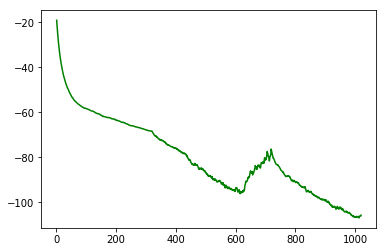

In [73]:
x = [i for i in range(1, len(costAccumulated1)+1)]
plt.plot(x, costAccumulated1, color='green')
#plt.plot(x, costAccumulated2, color='red')